In [1]:
# !pip install langchain-core==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22 python-dotenv==1.0.1

In [12]:
import operator
from typing import Annotated, Any, Optional

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.graph import END, StateGraph

from IPython.display import Image
import nest_asyncio

In [3]:
import os

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="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"
os.environ["LANGCHAIN_PROJECT"]="AI-Agent"

# データ構造の定義
## 各データモデル

In [4]:
# ペルソナを表すデータモデル
class Persona(BaseModel):
    name: str = Field(..., description="ペルソナの名前")
    background: str = Field(..., description="ペルソナの持つ背景")

# ペルソナのリストを表すデータモデル
class Personas(BaseModel):
    personas: list[Persona] = Field(
        default_factory=list, 
        description="ペルソナのリスト"
    )

# インタビュー内容を表すデータモデル
class Interview(BaseModel):
    persona: Persona = Field(..., description="インタビュー対象のペルソナ")
    question: str = Field(..., description="インタビューでの質問")
    answer: str = Field(..., description="インタビューでの回答")

# インタビュー結果のリストを表すデータモデル
class InterviewResult(BaseModel):
    interviews: list[Interview] = Field(
        default_factory=list, 
        description="インタビュー結果のリスト"
    )

# 評価の結果を表すデータモデル
class EvaluationResult(BaseModel):
    reason: str = Field(..., description="判断の理由")
    is_sufficient: bool = Field(..., description="情報が十分かどうか")

## 要件定義生成AIエージェントのステート

In [5]:
class InterviewState(BaseModel):
    user_request: str = Field(..., description="ユーザーからのリクエスト")
    personas: Annotated[list[Persona], operator.add] = Field(
        default_factory=list, 
        description="生成されたペルソナのリスト"
    )
    interviews: Annotated[list[Interview], operator.add] = Field(
        default_factory=list, 
        description="実施されたインタビューのリスト"
    )
    requirements_doc: str = Field(
        default="", 
        description="生成された要件定義"
    )
    iteration: int = Field(
        default=0, 
        description="ペルソナ生成とインタビューの反復回数"
    )
    is_information_sufficient: bool = Field(
        default=False, 
        description="情報が十分かどうか"
    )

# 主要コンポーネントの実装
## PersonaGenerator

In [6]:
class PersonaGenerator:
    def __init__(self, llm: ChatOpenAI, k: int = 5):
        self.llm = llm.with_structured_output(Personas)
        self.k = k

    def run(self, user_request: str) -> Personas:
        # プロンプトテンプレートを定義
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "あなたはユーザーインタビュー用の多様なペルソナを作成する専門家です。",
                ),
                (
                    "human",
                    f"以下のユーザーリクエストに関するインタビュー用に、{self.k}人の多様なペルソナを生成してください。\n\n"
                    "ユーザーリクエスト: {user_request}\n\n"
                    "各ペルソナには名前と簡単な背景を含めてください。年齢、性別、職業、技術的専門知識において多様性を確保してください。",
                ),
            ]
        )
        # ペルソナ生成のためのチェーンを作成
        chain = prompt | self.llm
        # ペルソナを生成
        return chain.invoke({"user_request": user_request})

## InterviewConductor

In [7]:
class InterviewConductor:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm

    def run(self, user_request: str, personas: list[Persona]) -> InterviewResult:
        # 質問を生成
        questions = self._generate_questions(
            user_request=user_request,
            personas=personas
        )
        # 回答を生成
        answers = self._generate_answers(
            personas=personas,
            questions=questions
        )
        # 質問と回答の組み合わせからインタビューリストを作成
        interviews = self._create_interviews(
            personas=personas,
            questions=questions,
            answers=answers
        )
        # インタビュー結果を返す
        return InterviewResult(interviews=interviews)

    def _generate_questions(self, user_request: str, personas: list[Persona]) -> list[str]:
        # 質問生成のためのプロンプトを定義
        question_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "あなたはユーザー要件に基づいて適切な質問を生成する専門家です。",
                ),
                (
                    "human",
                    "以下のペルソナに関連するユーザーリクエストについて、1つの質問を生成してください。\n\n"
                    "ユーザーリクエスト: {user_request}\n"
                    "ペルソナ: {persona_name} - {persona_background}\n\n"
                    "質問は具体的で、このペルソナの視点から重要な情報を引き出すように設計してください。",
                ),
            ]
        )
        # 質問生成のためのChainを生成
        question_chain = question_prompt | self.llm | StrOutputParser()

        # 各ペルソナに対する質問クエリを作成
        question_queries = [
            {
                "user_request": user_request,
                "persona_name": persona.name,
                "persona_background": persona.background,
            }
            for persona in personas
        ]

        # 質問をバッチ処理で生成(invokeではなく、batchで実行)
        return question_chain.batch(question_queries)

    def _generate_answers(self, personas: list[Persona], questions: list[str]) -> list[str]:
        # 回答生成のためのプロンプトを定義
        answer_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "あなたは以下のペルソナとして回答しています: {persona_name} - {persona_background}",
                ),
                ("human", "質問: {question}"),
            ]
        )
        # 回答生成のためのChainを作成
        answer_chain = answer_prompt | self.llm | StrOutputParser()

        # 各ペルソナに対する回答クエリを作成
        answer_queries = [
            {
                "persona_name": persona.name,
                "persona_background": persona.background,
                "question": question,
            }
            for persona, question in zip(personas, questions)
        ]

        # 回答をバッチ処理で生成(invokeではなく、batchで実行）
        return answer_chain.batch(answer_queries)

    def _create_interviews(self, personas: list[Persona], questions: list[str], answers: list[str]) -> list[Interview]:
        # ペルソナごとに質問と回答の組み合わせからインタビューオブジェクトを作成
        return [
            Interview(persona=persona, question=question, answer=answer)
            for persona, question, answer in zip(personas, questions, answers)
        ]

## InformationEvaluator
- 収集した情報が要件定義書を生成するために十分かどうかを評価する

In [8]:
class InformationEvaluator:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm.with_structured_output(EvaluationResult)

    # ユーザーリクエストとインタビュー結果をもとに情報の十分性を評価
    def run(self, user_request: str, interviews: list[Interview]) -> EvaluationResult:
        # プロンプトを定義
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "あなたは包括的な要件文書を作成するための情報の十分性を評価する専門家です。",
                ),
                (
                    "human",
                    "以下のユーザーリクエストとインタビュー結果に基づいて、包括的な要件文書を作成するのに十分な情報が集まったかどうかを判断してください。\n\n"
                    "ユーザーリクエスト: {user_request}\n\n"
                    "インタビュー結果:\n{interview_results}",
                ),
            ]
        )
        # 情報の十分性を評価するChainを作成
        chain = prompt | self.llm
        # 評価結果を返す
        return chain.invoke(
            {
                "user_request": user_request,
                "interview_results": "\n".join(
                    f"ペルソナ: {i.persona.name} - {i.persona.background}\n"
                    f"質問: {i.question}\n回答: {i.answer}\n"
                    for i in interviews
                ),
            }
        )
    

## RequirementsDocumentGenerator
- 最終的な要件定義書を生成

In [9]:
class RequirementsDocumentGenerator:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm

    def run(self, user_request: str, interviews: list[Interview]) -> str:
        # プロンプトを定義
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system", "あなたは収集した情報に基づいて要件文書を作成する専門家です。",
                ),
                (
                    "human",
                    "以下のユーザーリクエストと複数のペルソナからのインタビュー結果に基づいて、要件文書を作成してください。\n\n"
                    "ユーザーリクエスト: {user_request}\n\n"
                    "インタビュー結果:\n{interview_results}\n"
                    "要件文書には以下のセクションを含めてください:\n"
                    "1. プロジェクト概要\n"
                    "2. 主要機能\n"
                    "3. 非機能要件\n"
                    "4. 制約条件\n"
                    "5. ターゲットユーザー\n"
                    "6. 優先順位\n"
                    "7. リスクと軽減策\n\n"
                    "出力は必ず日本語でお願いします。\n\n要件文書:",
                ),
            ]
        )
        # 要件定義書を生成するChainを作成
        chain = prompt | self.llm | StrOutputParser()
        # 要件定義書を生成
        return chain.invoke(
            {
                "user_request": user_request,
                "interview_results": "\n".join(
                    f"ペルソナ: {i.persona.name} - {i.persona.background}\n"
                    f"質問: {i.question}\n回答: {i.answer}\n"
                    for i in interviews
                ),
            }
        )


# ワークフロー構築

In [13]:
class DocumentationAgent:
    def __init__(self, llm: ChatOpenAI, k: Optional[int] = None):
        # 各種ジェネレータの初期化
        self.persona_generator = PersonaGenerator(llm=llm, k=k)
        self.interview_conductor = InterviewConductor(llm=llm)
        self.information_evaluator = InformationEvaluator(llm=llm)
        self.requirements_generator = RequirementsDocumentGenerator(llm=llm)

        # グラフの作成
        self.graph = self._create_graph()

    def _create_graph(self) -> StateGraph:
        # グラフの初期化
        workflow = StateGraph(InterviewState)

        # 各ノードの追加
        workflow.add_node("generate_personas", self._generate_personas)
        workflow.add_node("conduct_interviews", self._conduct_interviews)
        workflow.add_node("evaluate_information", self._evaluate_information)
        workflow.add_node("generate_requirements", self._generate_requirements)

        # エントリーポイントの設定
        workflow.set_entry_point("generate_personas")

        # ノード間のエッジの追加
        workflow.add_edge("generate_personas", "conduct_interviews")
        workflow.add_edge("conduct_interviews", "evaluate_information")

        # 条件付きエッジの追加
        workflow.add_conditional_edges(
            "evaluate_information",
            lambda state: not state.is_information_sufficient and state.iteration < 5,
            {True: "generate_personas", False: "generate_requirements"},
        )
        workflow.add_edge("generate_requirements", END)

        # グラフのコンパイル
        return workflow.compile()

    def _generate_personas(self, state: InterviewState) -> dict[str, Any]:
        # ペルソナの生成
        new_personas: Personas = self.persona_generator.run(state.user_request)
        return {
            "personas": new_personas.personas,
            "iteration": state.iteration + 1,
        }

    def _conduct_interviews(self, state: InterviewState) -> dict[str, Any]:
        # インタビューの実施
        new_interviews: InterviewResult = self.interview_conductor.run(
            state.user_request, state.personas[-5:]
        )
        return {"interviews": new_interviews.interviews}

    def _evaluate_information(self, state: InterviewState) -> dict[str, Any]:
        # 情報の評価
        evaluation_result: EvaluationResult = self.information_evaluator.run(
            state.user_request, state.interviews
        )
        return {
            "is_information_sufficient": evaluation_result.is_sufficient,
            "evaluation_reason": evaluation_result.reason,
        }

    def _generate_requirements(self, state: InterviewState) -> dict[str, Any]:
        # 要件定義書の生成
        requirements_doc: str = self.requirements_generator.run(
            state.user_request, state.interviews
        )
        return {"requirements_doc": requirements_doc}

    def graph_visualization(self):
        nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    def run(self, user_request: str) -> str:
        # 初期状態の設定
        initial_state = InterviewState(user_request=user_request)
        # グラフの実行
        final_state = self.graph.invoke(initial_state)
        # 最終的な要件定義書の取得
        return final_state["requirements_doc"]


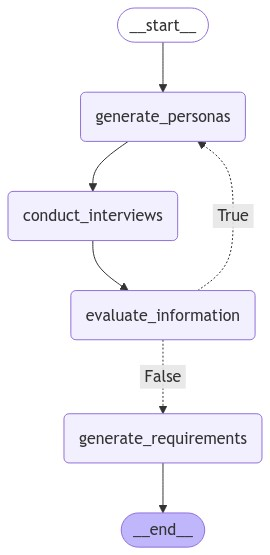

In [14]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
agent = DocumentationAgent(llm=llm, k=5)
agent.graph_visualization()

# メイン関数

In [11]:
def main():
    task = "スマートフォン向けの健康管理アプリを開発したい"
    k = 5 #生成するペルソナの人数

    # ChatOpenAIモデルを初期化
    llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
    # 要件定義書生成AIエージェントを初期化
    agent = DocumentationAgent(llm=llm, k=k)
    # エージェントを実行して最終的な出力を取得
    final_output = agent.run(user_request=task)
    # 最終的な出力を表示
    print(final_output)

if __name__ == "__main__":
    main()


# 健康管理アプリ要件文書

## 1. プロジェクト概要
本プロジェクトは、スマートフォン向けの健康管理アプリを開発することを目的としています。このアプリは、ユーザーが日常生活の中で健康を管理し、ストレスを軽減するためのサポートを提供します。ターゲットユーザーは、技術的なスキルやライフスタイルが異なる多様な層を含みます。

## 2. 主要機能
1. **シンプルで直感的なインターフェース**: ユーザーが簡単に操作できるデザインを提供し、日々の健康データの入力を容易にします。
   
2. **リマインダー機能**: ユーザーのスケジュールに合わせたリマインダーを設定し、健康管理の習慣化をサポートします。

3. **パーソナライズされたアドバイス**: ユーザーの健康データに基づき、個別のアドバイスや改善策を提供します。

4. **進捗の可視化**: グラフやチャートを用いて、ユーザーの健康状態やストレス管理の進捗を視覚的に表示します。

5. **コミュニティサポート**: 同じ目標を持つユーザー同士が情報交換や励まし合いができるプラットフォームを提供します。

6. **ストレス軽減コンテンツ**: 瞑想やリラクゼーションのガイド、短時間でできるエクササイズを提供します。

7. **自動データ同期**: ウェアラブルデバイスやスマートウォッチと連携し、健康データを自動で同期します。

8. **家族アカウントの連携**: 家族全員の健康データを一元管理し、各メンバーの健康状態を把握できる機能を提供します。

9. **データのカスタマイズと分析**: ユーザーが自分の健康データをカスタマイズし、詳細な分析を行える機能を提供します。

## 3. 非機能要件
- **ユーザビリティ**: すべてのユーザーが直感的に操作できるインターフェースを提供します。
- **パフォーマンス**: アプリの動作は迅速で、データ同期や分析がリアルタイムで行われることを保証します。
- **セキュリティ**: ユーザーの健康データを安全に保護し、プライバシーを確保します。
- **多言語対応**: 日本語を含む複数の言語に対応します。

## 4. 制約条件
- **プラットフォーム**: iOSおよびAndroidでの動作を保証します。
- **デバイス互換性**: 最